# Climate Data Challenge 2022.
## Seasonal variability of crime for the London Metropolitan area, 2010-2022. 

In [10]:
import pandas as pd 
import numpy as np
from scipy.stats import pearsonr
from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [11]:
#load crime data
crim_path_dir = "MOJ-Climate-Change-and-Crime/"
Ldn_crime = pd.read_pickle("mps.borough.crime.2010-2021.pickle")
Ldn_crime

,MajorText,MinorText,borough,yearmonth,value,date,month,year
0,Arson and Criminal Damage,Arson,Barking and Dagenham,201004,6,2010-04-01,4,2010
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,201004,208,2010-04-01,4,2010
2,Burglary,Burglary Business and Community,Barking and Dagenham,201004,49,2010-04-01,4,2010
3,Burglary,Domestic Burglary,Barking and Dagenham,201004,118,2010-04-01,4,2010
4,Drug Offences,Drug Trafficking,Barking and Dagenham,201004,9,2010-04-01,4,2010
...,...,...,...,...,...,...,...,...
243403,Vehicle Offences,Theft from a Motor Vehicle,Westminster,202203,290,2022-03-01,3,2022
243404,Vehicle Offences,Theft or Taking of a Motor Vehicle,Westminster,202203,51,2022-03-01,3,2022
243405,Violence Against the Person,Homicide,Westminster,202203,0,2022-03-01,3,2022
243406,Violence Against the Person,Violence with Injury,Westminster,202203,347,2022-03-01,3,2022


In [12]:
#load climate data
clim_path_dir = "climate_data/"
clim_vals = pd.read_csv(clim_path_dir+"monthly_climate_actuals_London_2001_2022.csv")
clim_vals

,month,mean_temperature,max_temperature,rainfall,raindays_gt_1mm,raindays_gt_10mm,sunshine_hours,humidity
0,01/01/2001,4.13844,6.94144,70.56545,12.17965,1.94158,67.43305,84.78743
1,01/02/2001,5.66318,8.98160,90.76535,12.96168,2.99560,80.63946,82.68405
2,01/03/2001,6.50429,9.36969,99.83895,14.39259,3.13756,66.53335,83.20217
3,01/04/2001,8.88921,12.71305,75.51019,16.81910,1.32035,132.29852,75.24798
4,01/05/2001,13.55181,18.62517,40.47370,6.20477,1.10364,230.06488,70.21018
...,...,...,...,...,...,...,...,...
252,01/01/2022,5.13069,8.75949,17.35631,4.93467,0.06533,73.18827,NaN
253,01/02/2022,7.63860,11.18567,58.07263,12.54334,1.14259,87.55723,NaN
254,01/03/2022,8.74571,12.95951,26.90577,5.03141,0.78518,165.15224,NaN
255,01/04/2022,10.24891,15.38764,20.81225,2.95980,0.90327,180.97978,NaN


In [13]:
#bank holiday impact
BHs_dir = "climate_data/"
BHs = pd.read_csv(BHs_dir+"BH_weekend_flipped.csv")
BHs

,Year,Month,BH,Weekend days,Total non-work days
0,2010,Jan,1.0,8,9
1,2010,Feb,NaN,8,8
2,2010,Mar,NaN,8,8
3,2010,Apr,2.0,8,10
4,2010,May,2.0,10,12
...,...,...,...,...,...
143,2021,Dec,2.0,8,10
144,2022,Jan,1.0,10,11
145,2022,Feb,NaN,8,8
146,2022,Mar,NaN,8,8


In [6]:
#what crimes are there?
pd.unique(Ldn_crime["MajorText"])

array(['Arson and Criminal Damage', 'Burglary', 'Drug Offences',
       'Historical Fraud and Forgery',
       'Miscellaneous Crimes Against Society', 'Possession of Weapons',
       'Public Order Offences', 'Robbery', 'Sexual Offences', 'Theft',
       'Vehicle Offences', 'Violence Against the Person'], dtype=object)

In [7]:
# combine over regions
Ldn_crime['month'] = pd.to_datetime(Ldn_crime['yearmonth'], format="%Y%m").dt.date
Ldn_crime = Ldn_crime.set_index('month')

Ldn_crime_major = pd.pivot_table(Ldn_crime, values='value', index='month', columns='MajorText', aggfunc=np.sum)
Ldn_crime_major

MajorText,Arson and Criminal Damage,Burglary,Drug Offences,Historical Fraud and Forgery,Miscellaneous Crimes Against Society,Possession of Weapons,Public Order Offences,Robbery,Sexual Offences,Theft,Vehicle Offences,Violence Against the Person
month,,,,,,,,,,,,
2010-04-01,7534.0,7175.0,5244.0,1726.0,619.0,480.0,2539.0,2989.0,838.0,19450.0,8874.0,12065.0
2010-05-01,7280.0,7188.0,5303.0,1841.0,678.0,476.0,2687.0,3257.0,939.0,19532.0,9028.0,13018.0
2010-06-01,7483.0,7196.0,5248.0,1831.0,656.0,458.0,2707.0,2924.0,903.0,19935.0,9475.0,13209.0
2010-07-01,7430.0,7149.0,5931.0,2053.0,730.0,500.0,2900.0,2788.0,971.0,21086.0,8588.0,13321.0
2010-08-01,6729.0,7248.0,6447.0,1874.0,652.0,464.0,2436.0,2481.0,756.0,18877.0,8283.0,11591.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,4570.0,4973.0,3920.0,NaN,970.0,529.0,5108.0,2277.0,2312.0,19361.0,9783.0,20481.0
2021-12-01,4244.0,4719.0,3506.0,NaN,895.0,483.0,4435.0,2016.0,1834.0,17321.0,8759.0,19186.0
2022-01-01,4358.0,4882.0,4331.0,NaN,930.0,524.0,4244.0,2075.0,2013.0,16705.0,9201.0,19208.0


In [8]:
#set the same datetime format for the climate data
clim_vals.set_index('month',inplace=True)
clim_vals.head(5)

,mean_temperature,max_temperature,rainfall,raindays_gt_1mm,raindays_gt_10mm,sunshine_hours,humidity
month,,,,,,,
01/01/2001,4.13844,6.94144,70.56545,12.17965,1.94158,67.43305,84.78743
01/02/2001,5.66318,8.98160,90.76535,12.96168,2.99560,80.63946,82.68405
01/03/2001,6.50429,9.36969,99.83895,14.39259,3.13756,66.53335,83.20217
01/04/2001,8.88921,12.71305,75.51019,16.81910,1.32035,132.29852,75.24798
01/05/2001,13.55181,18.62517,40.47370,6.20477,1.10364,230.06488,70.21018


## Examine some of the crimes for potential seasonal cycles which will then look to control using the following three factors:
### days per month
### holidays per month
### trend


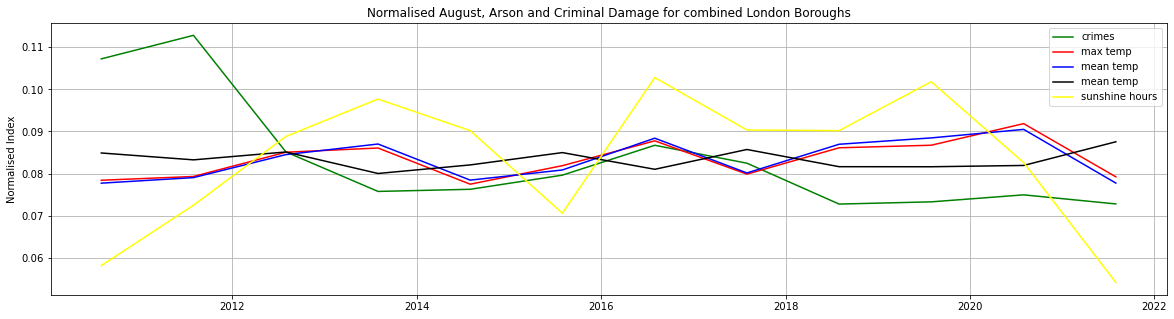

In [151]:
cr_choice = "Arson and Criminal Damage"
Aug_riots = Ldn_crime_major[[cr_choice]].values[4::12]/np.sum(Ldn_crime_major[[cr_choice]].values[4::12])
mean_temp=clim_vals[['mean_temperature']].values[115::12]/np.sum(clim_vals[['mean_temperature']].values[115::12])
max_temp=clim_vals[['max_temperature']].values[115::12]/np.sum(clim_vals[['max_temperature']].values[115::12])
sun_hours=clim_vals[['sunshine_hours']].values[115::12]/np.sum(clim_vals[['sunshine_hours']].values[115::12])
humid =clim_vals[['humidity']].values[115::12]/np.sum(clim_vals[['humidity']].values[115::12])
plt.figure(figsize=(20,5))
plt.plot(Ldn_crime_major.index[4::12],Aug_riots, color='green',label='crimes')
plt.plot(Ldn_crime_major.index[4::12],mean_temp, color='red',label='max temp')
plt.plot(Ldn_crime_major.index[4::12],max_temp, color='blue',label='mean temp')
plt.plot(Ldn_crime_major.index[4::12],humid, color='black',label='mean temp')
plt.plot(Ldn_crime_major.index[4::12],sun_hours, color='yellow',label='sunshine hours')
plt.title('Normalised August, Arson and Criminal Damage for combined London Boroughs')
plt.ylabel('Normalised Index')
plt.grid()
plt.legend(loc = 'upper right')

### Public Order offences seasonal cycle

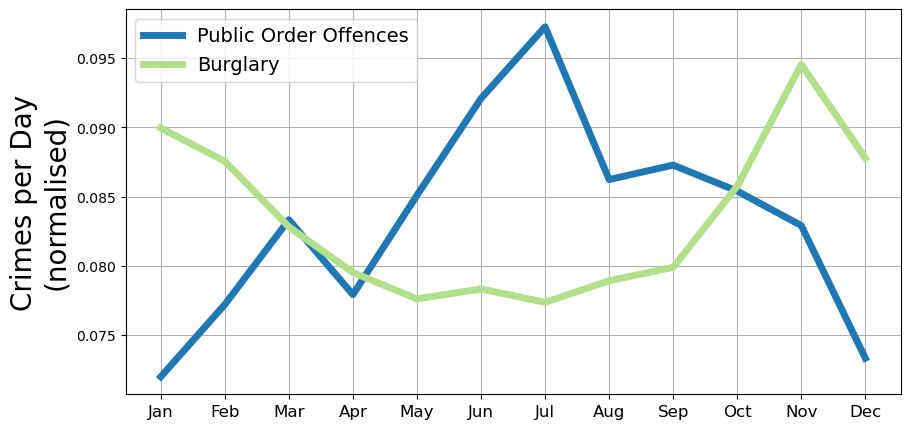

In [26]:

pub_order = np.zeros(12,)
Burg_order = np.zeros(12,)
Theft_order = np.zeros(12,)
sex_order = np.zeros(12,)
vehicle_order = np.zeros(12,)
cycle_BHs = np.zeros(12,)
for month in range(0,12):
    pub_order[month] = np.sum(Ldn_crime_major[["Public Order Offences"]].values[month::12])
    Burg_order[month] = np.sum(Ldn_crime_major[["Burglary"]].values[month::12])
    Theft_order[month] = np.sum(Ldn_crime_major[["Theft"]].values[month::12])
    sex_order[month] = np.sum(Ldn_crime_major[["Sexual Offences"]].values[month::12])
    vehicle_order[month] = np.sum(Ldn_crime_major[["Vehicle Offences"]].values[month::12])
    cycle_BHs[month] = np.sum(BHs[['Total non-work days']].values[month::12])
#control for days per month
dpr=[31,28.5,31,30,31,30,31,31,30,31,30,31]
#reorder so jan first
pub_chron = [pub_order[i] for i in [9,10,11,0,1,2,3,4,5,6,7,8]]
burg_chron = [Burg_order[i] for i in [9,10,11,0,1,2,3,4,5,6,7,8]]
theft_chron = [Theft_order[i] for i in [9,10,11,0,1,2,3,4,5,6,7,8]]
sex_chron = [sex_order[i] for i in [9,10,11,0,1,2,3,4,5,6,7,8]]
vehicle_chron = [vehicle_order[i] for i in [9,10,11,0,1,2,3,4,5,6,7,8]]
#crimes per day
pub_perday = np.array(pub_chron) / np.array(dpr)
burg_perday = np.array(burg_chron) / np.array(dpr)
theft_perday = np.array(theft_chron) / np.array(dpr)
sex_perday = np.array(sex_chron) / np.array(dpr)
vehicle_perday = np.array(vehicle_chron) / np.array(dpr)

plt.figure(figsize=(10,5))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

# matplotlib.rc('font', **font)
plt.plot(np.arange(12),pub_perday / np.sum(pub_perday), color='#1f78b4',linewidth=5, label='Public Order Offences')
plt.plot(np.arange(12),burg_perday / np.sum(burg_perday), color='#b2df8a',linewidth=5, label='Burglary')
#plt.plot(np.arange(12),theft_perday / np.sum(theft_perday), color='blue',linewidth=2.5, label='Theft')
#plt.plot(np.arange(12),sex_perday / np.sum(sex_perday), color='cyan',linewidth=2.5, label='Sexual Offences')
#plt.plot(np.arange(12),vehicle_perday / np.sum(vehicle_perday), color='magenta',linewidth=2.5, label='Vehicle Offences')
plt.xticks(np.arange(12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], fontsize=12)
# plt.title('Seasonal Cycle of Burglary and Public Order Offences for London 2011-2022',fontsize=20)
plt.ylabel('Crimes per Day\n(normalised)',fontsize=20)
plt.grid()
plt.legend(loc = 'upper left', fontsize=14)
plt.savefig("seasonal_cycle", dpi=300)

In [262]:
#compare to anomaly weather
dt_pub_order=np.zeros((12,3))
dt_temp_ppo=np.zeros((12,3))
from sklearn.linear_model import LinearRegression
peak_pub_order=[Ldn_crime_major[["Burglary"]].values[2::12] / 30, Ldn_crime_major[["Public Order Offences"]].values[3::12] / 31]
mean_temp_ppo = [clim_vals[['mean_temperature']].values[113::12], clim_vals[['mean_temperature']].values[114::12]]
for ms in range(0,2):
    model = LinearRegression()
    model_temp = LinearRegression()
    X = [i for i in range(0, len(jun_punord))]
    X = np.reshape(X, (len(X), 1))
    model.fit(X, peak_pub_order[ms])
    model_temp.fit(X, mean_temp_ppo[ms])
    # calculate trend
    trend = model.predict(X)
    trend_temp = model_temp.predict(X)
    # detrend
    dt_pub_order[:,ms] = [peak_pub_order[ms][i]-trend_temp[i] for i in range(0, len(jun_punord))]
    dt_temp_ppo[:,ms] = [mean_temp_ppo[ms][i]-trend_temp[i] for i in range(0, len(jun_punord))]

Text(0.5, 0, 'Detrended Public Order Offences per day for June and July')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


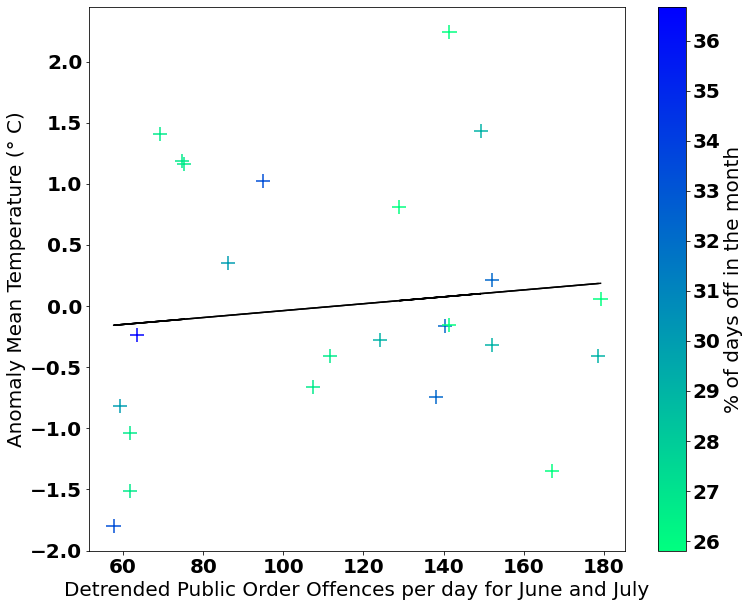

In [366]:
from numpy.polynomial.polynomial import polyfit
import matplotlib
dh_cols = [BHs[['Total non-work days']].values[5::12] /.3, BHs[['Total non-work days']].values[6::12] / .31]
cmap = plt.get_cmap('magma',6)
b, m = polyfit(np.reshape(dt_pub_order,(24,)),np.reshape(dt_temp_ppo,(24,)),1)
plt.figure(figsize=(12,10))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)
plt.scatter(dt_pub_order, dt_temp_ppo, s=200, c=dh_cols, marker='+',cmap='winter_r')
plt.plot(dt_pub_order, b+ m*dt_pub_order, '-', color='black')
cbar = plt.colorbar(ticks=np.arange(24,38,1))
cbar.set_label('% of days off in the month',fontsize=20)
#plt.plot(np.arange(0,25,1),color='black')
#
#plt.xlim(0,25)
#plt.ylim(0,25)
#plt.title('Comparison of real and simulated wind at Euro platform for Summer 2019')
plt.ylabel('Anomaly Mean Temperature (\u00b0 C)',fontsize=20)
plt.xlabel('Detrended Public Order Offences per day for June and July',fontsize=20)

In [344]:
np.max(dh_cols)

36.66666666666667

In [353]:
np.reshape(dt_temp_ppo,(24,1))

array([[ 1.18744077],
       [ 1.16103333],
       [-0.23548664],
       [-1.79967576],
       [-0.81852406],
       [-1.50964485],
       [-1.04032147],
       [ 1.40561606],
       [ 0.35228112],
       [ 1.02598697],
       [-0.40869629],
       [-0.66080212],
       [-0.27480371],
       [-0.16382121],
       [ 1.43075888],
       [-0.1581703 ],
       [ 0.80837147],
       [ 2.24286061],
       [-0.74446594],
       [ 0.21133152],
       [-0.31668336],
       [-1.34928758],
       [ 0.06012923],
       [-0.40542667]])

In [355]:
x=np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])